In [ ]:
!pip install nbconvert

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/My Drive/notebooks'

/content/drive/My Drive/notebooks


In [ ]:
!jupyter nbconvert --to html lab3.ipynb


[NbConvertApp] Converting notebook lab3.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 17 image(s).
[NbConvertApp] Writing 2560777 bytes to lab3.html


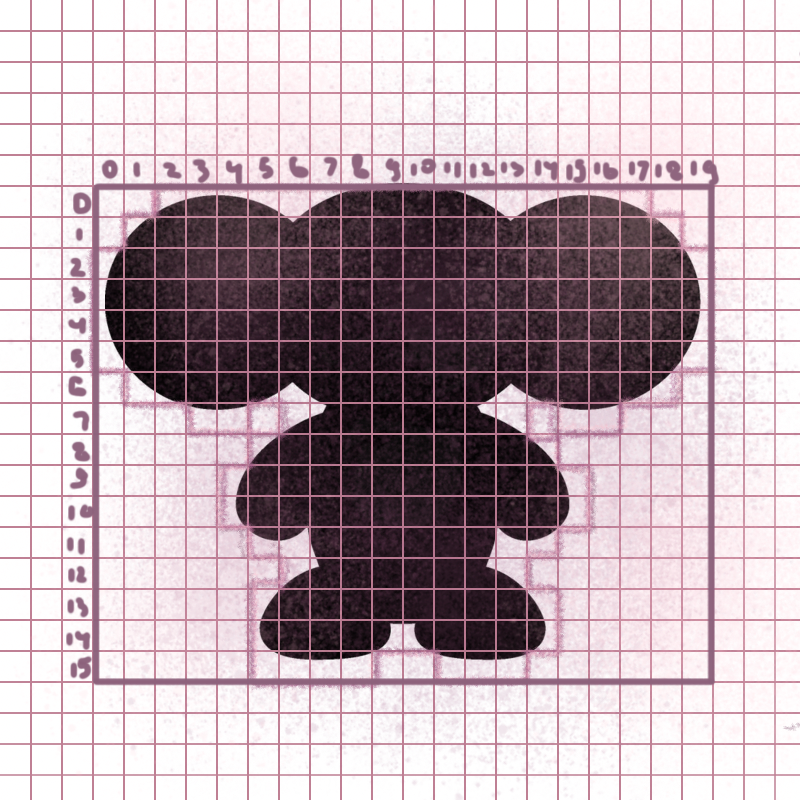

Кумирова Екатерина M34021

**Лабораторная работа №3**

Контур Чебурашки

In [ ]:
import math as mt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import plotly.express as px
import matplotlib.animation as animation
from IPython.display import Image
import matplotlib as mpl
import seaborn as sns


In [ ]:
mpl.style.use(['ggplot'])

### **Моделирование**

In [ ]:
from typing import Callable, Tuple

class Modeling:
    def __init__(self, seasonality: float, frequency: float, iterations: int, grid_size: Tuple[int, int], matrix: np.ndarray):
        self.iterations: int = iterations
        self.m: float = seasonality
        self.w: float = frequency

        self.tau: float = 0.001
        self.h_x: float = 0.01
        self.h_y: float = 0.01
        self.a_x: float = 0.1
        self.a_y: float = 0.1
        self.b: list[float] = [-1/24, 2/3, -5/4, 2/3, -1/24]
        self.d: list[float] = [-1/3, 1.5, -3, 11/6]

        self.time: np.ndarray = np.linspace(0, self.tau * self.iterations, self.iterations)
        self.external_influence_function: Callable[[float], float] = lambda t: 1 + self.m * np.cos(self.w * t)
        self.y_size, self.x_size = grid_size
        self.matrix: np.ndarray = matrix

        self.start_iter: int = 5
        self.u: np.ndarray = np.zeros([self.iterations, self.y_size, self.x_size], dtype='d')

        self._initialize_smooth_temperature_distribution()

    def _initialize_smooth_temperature_distribution(self) -> None:
        max_temperature, min_temperature, temperature_step = 150, 0, 1

        for iteration in range(self.start_iter):
            self.u[iteration, 0, :] = np.linspace(min_temperature, max_temperature, self.x_size)
            self.u[iteration, :, 0] = np.linspace(min_temperature, max_temperature, self.y_size)

            max_temperature -= temperature_step
            min_temperature += temperature_step

            for row in range(1, self.y_size):
                for col in range(1, self.x_size):
                    self.u[iteration][row][col] = (
                        self.u[iteration][row - 1][col] +
                        self.u[iteration][row][col - 1]
                    ) / 2

        mask: np.ndarray = self.matrix == 1
        for iteration in range(self.start_iter):
            self.u[iteration][mask] = 0

    def _is_outside_cell(self, row: int, col: int) -> bool:
        return self.matrix[row][col] == 1

    def _is_border(self, row: int, col: int) -> bool:
        neighbours: list[Tuple[int, int]] = [
            (row - 1, col), (row + 1, col),
            (row, col - 1), (row, col + 1)
        ]
        for neighbour_row, neighbour_col in neighbours:
            if (neighbour_row < 0 or neighbour_row >= self.y_size or
                neighbour_col < 0 or neighbour_col >= self.x_size):
                return True
            if self._is_outside_cell(neighbour_row, neighbour_col):
                return True
        return False

    def _compute_second_derivative_x(self, iteration: int, row: int, col: int) -> float:
        weights = self.b
        result = 0
        offsets = [-2, -1, 0, 1, 2]
        for idx, offset in enumerate(offsets):
            neighbour_col = col + offset
            if 0 <= neighbour_col < self.x_size and not self._is_outside_cell(row, neighbour_col):
                result += weights[idx] * self.u[iteration][row][neighbour_col]
            else:
                result += weights[idx] * self.u[iteration][row][col]
        return result / self.h_x

    def _compute_second_derivative_y(self, iteration: int, row: int, col: int) -> float:
        weights = self.b
        result = 0
        offsets = [-2, -1, 0, 1, 2]
        for idx, offset in enumerate(offsets):
            neighbour_row = row + offset
            if 0 <= neighbour_row < self.y_size and not self._is_outside_cell(neighbour_row, col):
                result += weights[idx] * self.u[iteration][neighbour_row][col]
            else:
                result += weights[idx] * self.u[iteration][row][col]
        return result / self.h_y

    def simulate_heat_transfer(self) -> None:
        for iteration in range(self.start_iter, self.iterations):
            for row in range(self.y_size):
                for col in range(self.x_size):
                    if self._is_outside_cell(row, col):
                        self.u[iteration][row][col] = 0
                        continue

                    boundary_function_value = 0
                    if self._is_border(row, col):
                        boundary_function_value = self.external_influence_function(self.time[iteration])

                    second_derivative_x = self._compute_second_derivative_x(iteration - 1, row, col)
                    second_derivative_y = self._compute_second_derivative_y(iteration - 1, row, col)

                    self.u[iteration][row][col] = (
                        self.tau * (
                            self.a_x * second_derivative_x +
                            self.a_y * second_derivative_y +
                            boundary_function_value
                        )
                        - self.d[0] * self.u[iteration - 3][row][col]
                        - self.d[1] * self.u[iteration - 2][row][col]
                        - self.d[2] * self.u[iteration - 1][row][col]
                    ) / self.d[3]

### **Дискретное разбиение двумерной области (Чебурашки) и расчет матрицы связей**

In [ ]:
def discretize_2d_area(y_size: int, x_size: int) -> np.ndarray:
    matrix = np.zeros((y_size, x_size), dtype=int)

    ranges = [
        (0, slice(0, 2)), (0, slice(18, 20)),
        (1, [0, 19]),
        (6, [0, 19]),
        (7, slice(0, 3)), (7, slice(17, 20)),
        (8, slice(0, 5)), (8, slice(15, 20)),
        (9, slice(0, 4)), (9, slice(16, 20)),
        (10, slice(0, 4)), (10, slice(16, 20)),
        (11, slice(0, 5)), (11, slice(15, 20)),
        (12, slice(0, 6)), (12, slice(14, 20)),
        (13, slice(0, 5)), (13, slice(15, 20)),
        (14, slice(0, 5)), (14, slice(15, 20)),
        (15, slice(0, 6)), (15, slice(9, 11)), (15, slice(14, 20)),
    ]
    for y, x in ranges:
        matrix[y][x] = 1
    return matrix

In [ ]:
y_size, x_size = 16, 20
matrix = discretize_2d_area(y_size, x_size)

In [ ]:
matrix

array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 0, 0, 0, 0,

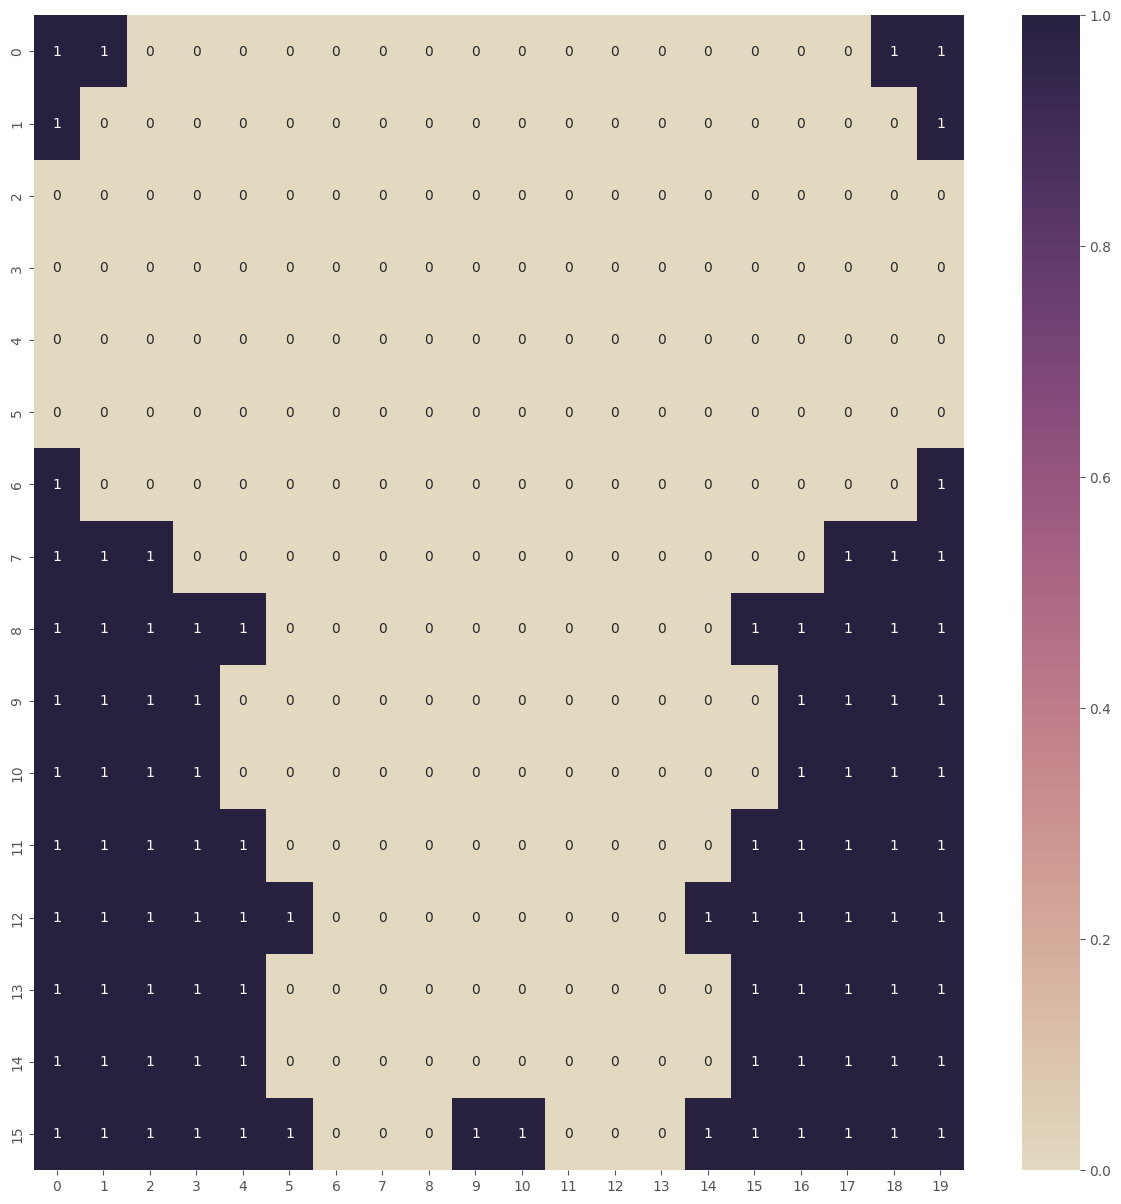

In [ ]:
plt.figure(figsize = (15, 15))
sns.heatmap(matrix, annot = True, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.show()

In [ ]:
model = Modeling(seasonality=1.0, frequency=1.0, iterations=10000, grid_size=(y_size, x_size), matrix=matrix)

In [ ]:
model.simulate_heat_transfer()

### **Визуализация распределения температур**

#### **Распределение температур в области в начальный момент времени и на нескольких последовательных временных слоях**

<Figure size 1500x2000 with 0 Axes>

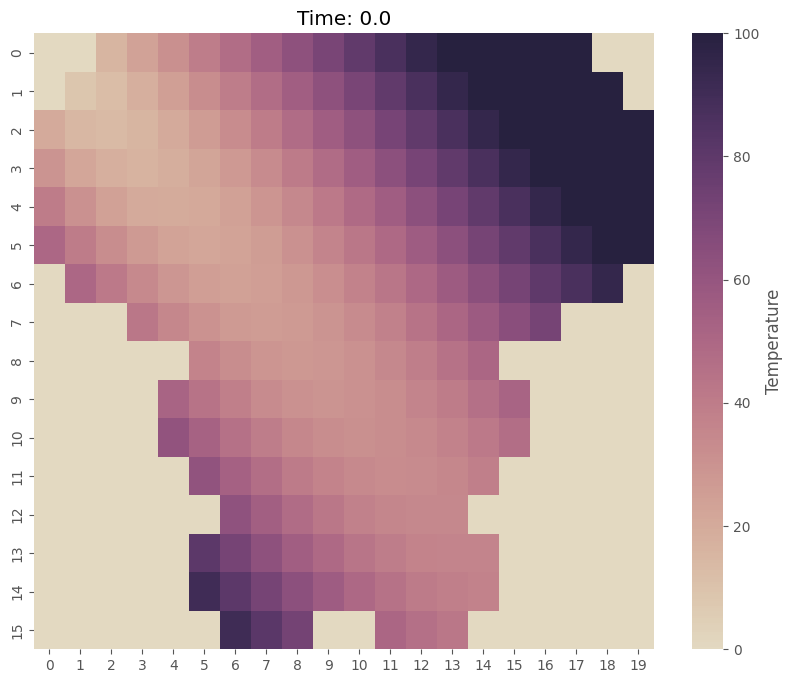

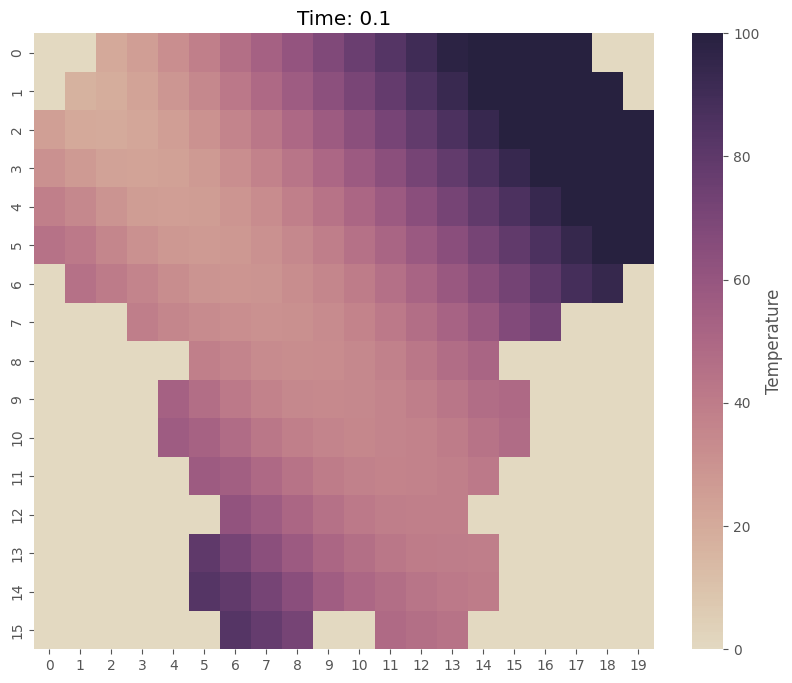

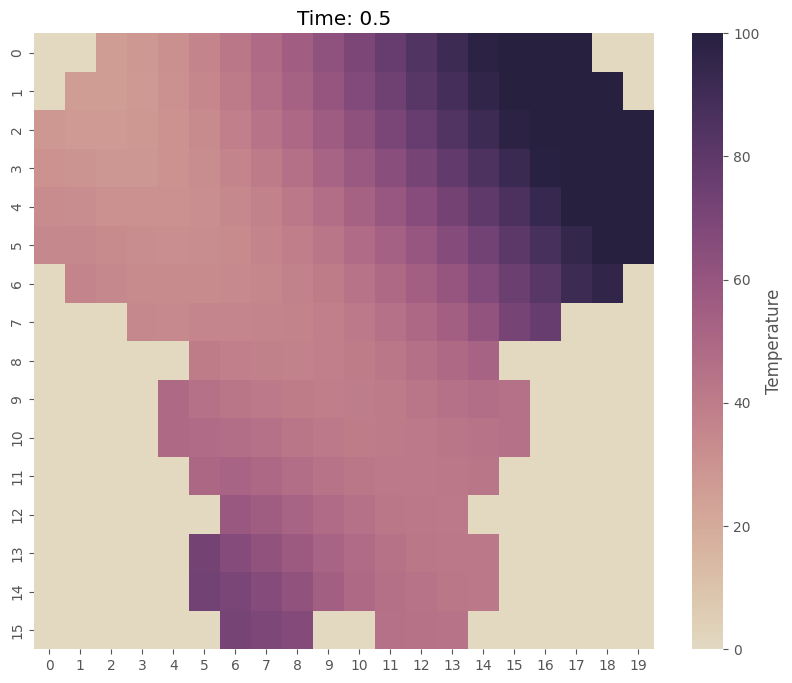

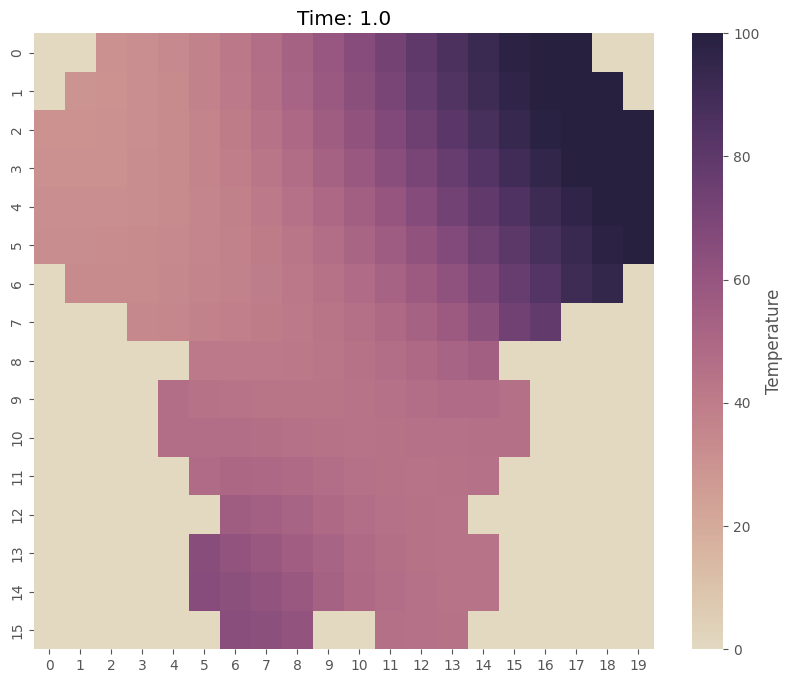

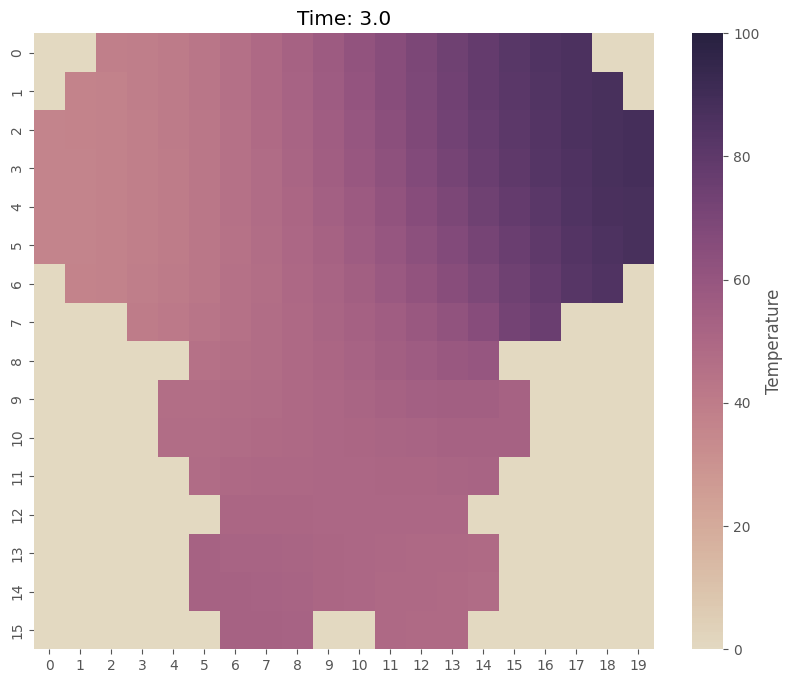

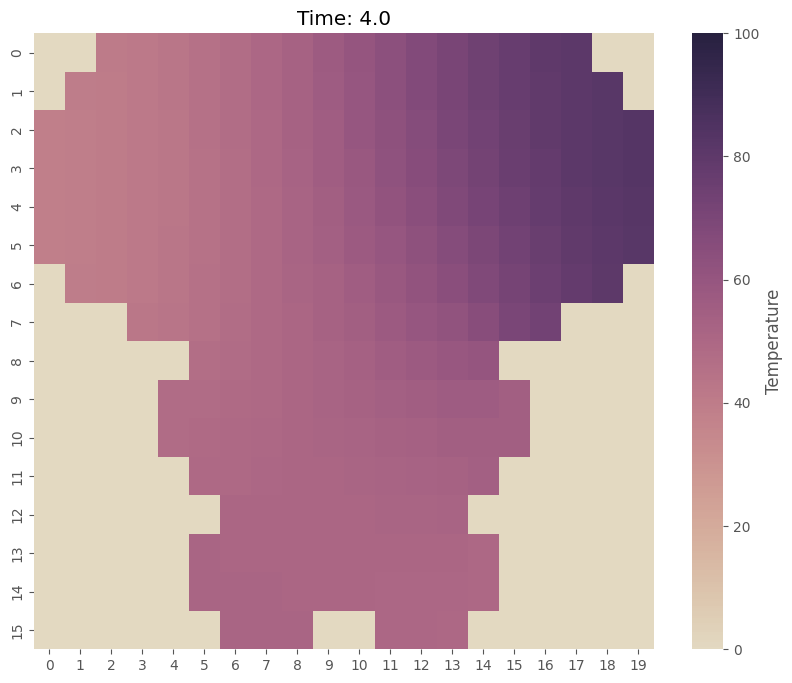

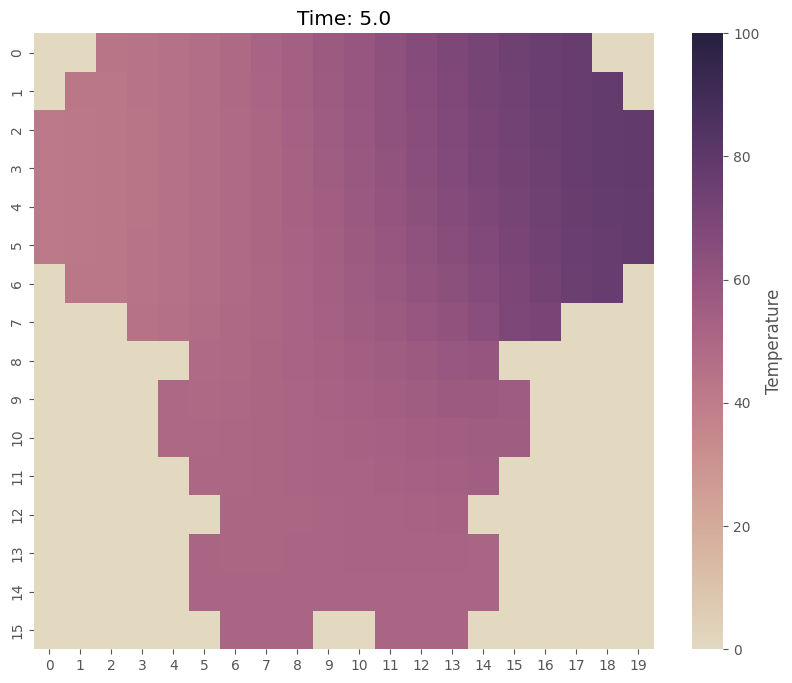

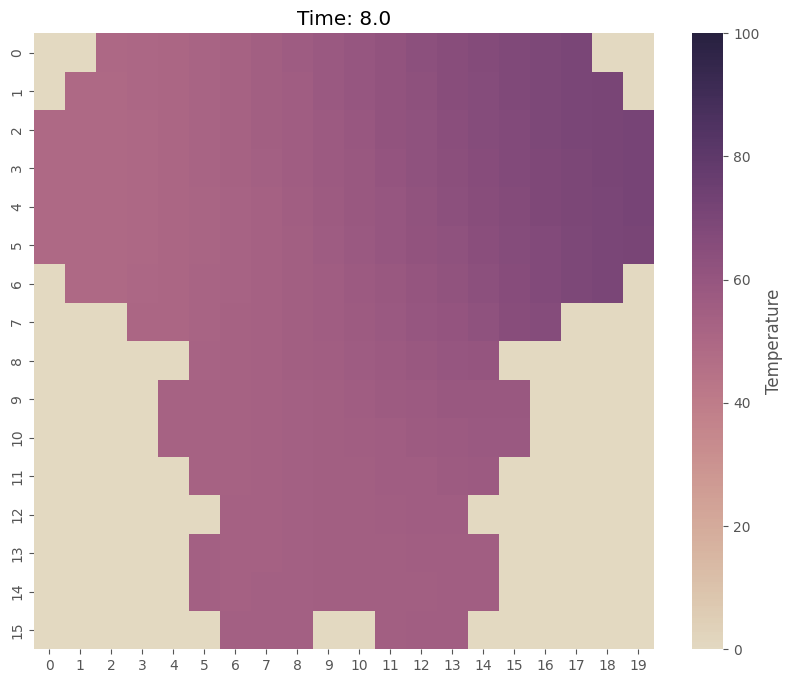

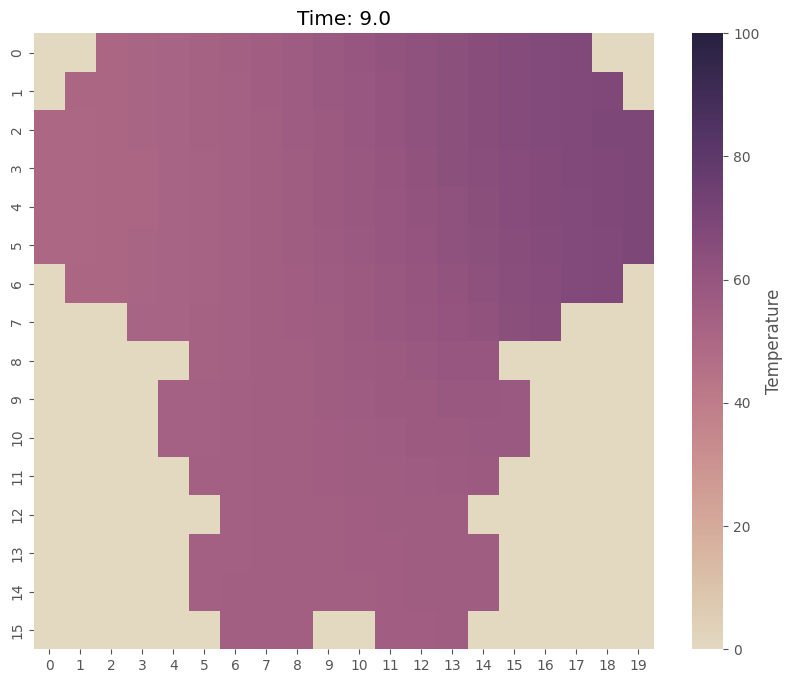

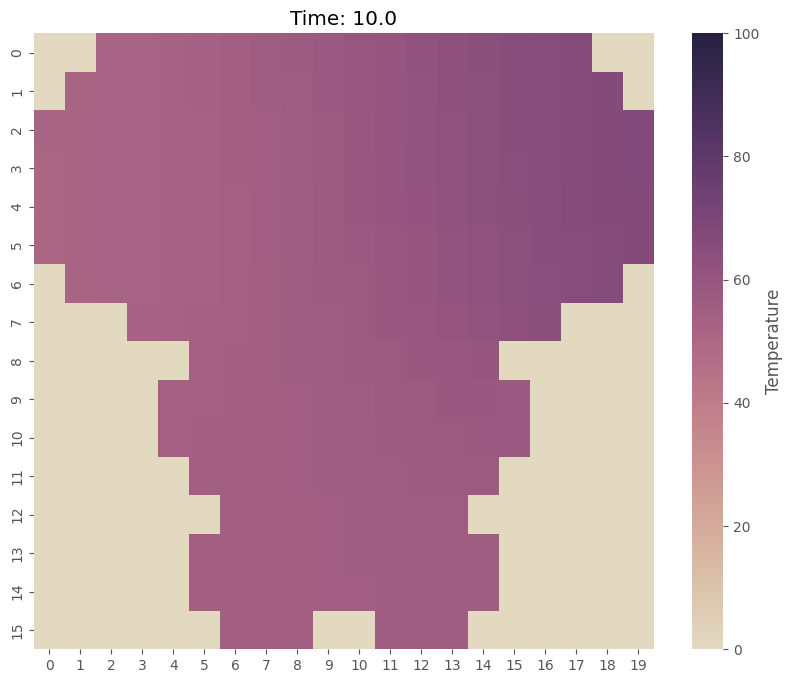

In [ ]:
iterations = [
    [0, 100, 500, 1000],  # ранние итерации
    [3000, 4000, 5000],  # средние итерации
    [8000, 9000, 9999]  # ближе к конечной итерации
]

fig = plt.figure(figsize=(15, 20))

for iteration_set in iterations:
    for iteration in iteration_set:
        plt.figure(figsize=(10, 8))

        sns.heatmap(model.u[iteration], cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),
                    cbar_kws={'label': 'Temperature'}, vmin=0, vmax=100)

        plt.title(f'Time: {round(model.time[iteration], 2)}')
        plt.show()

#### **Анимация**

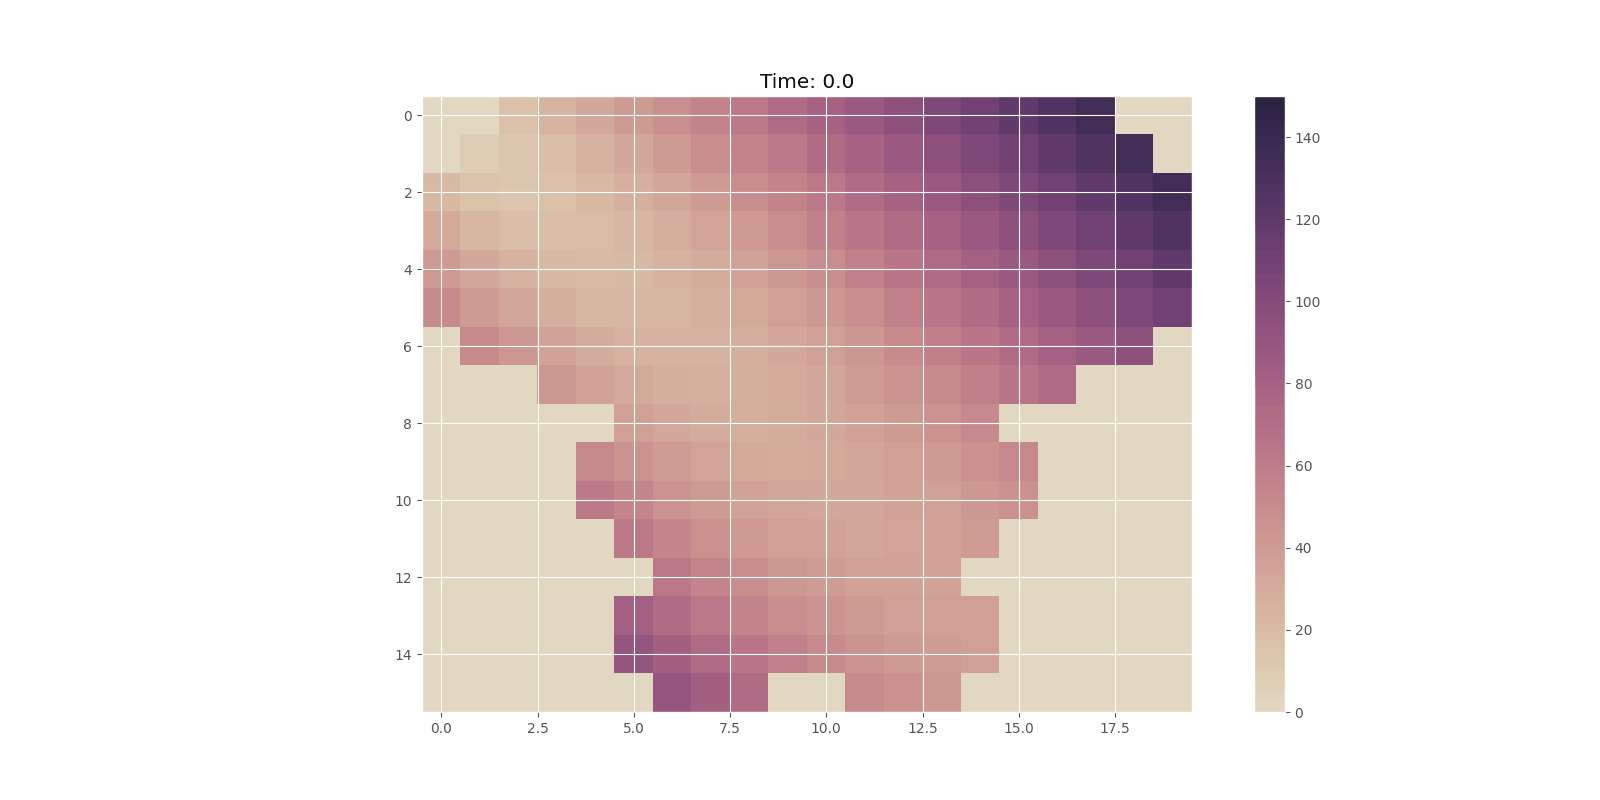

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
flag = True

def update(index):
    ax.clear()
    im = ax.imshow(model.u[index],
                   cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True),vmin=0, vmax=150)
    ax.set_title(f'Time: {round(model.time[index], 5)}')

    global flag
    if flag:
        plt.colorbar(im)
        flag = False

cheburashka_animation = animation.FuncAnimation(fig, update, frames=range(0, 9999, 100))
cheburashka_animation.save('cheburashka_temperature_distribution.gif', writer='imagemagick', fps=30)
plt.close()
Image(open('cheburashka_temperature_distribution.gif','rb').read())

#### **Графики изменения температуры в нескольких выбранных точках области**

In [ ]:
import matplotlib.pyplot as plt

def plot_temperature_distribution(model, coords, plot_color, xlim_range=(0, 10)):
    time = model.time

    for x, y in coords:
        u = model.u[:, x, y]

        plt.figure(figsize=(10, 8))
        plt.plot(time, u, color=plot_color)

        plt.xlim(xlim_range)
        plt.xlabel("Time")
        plt.ylabel("Temperature")

        plt.title(f"Cell with coordinates: x={x}, y={y}")
        plt.grid(True, which='both')
        plt.minorticks_on()

        plt.show()

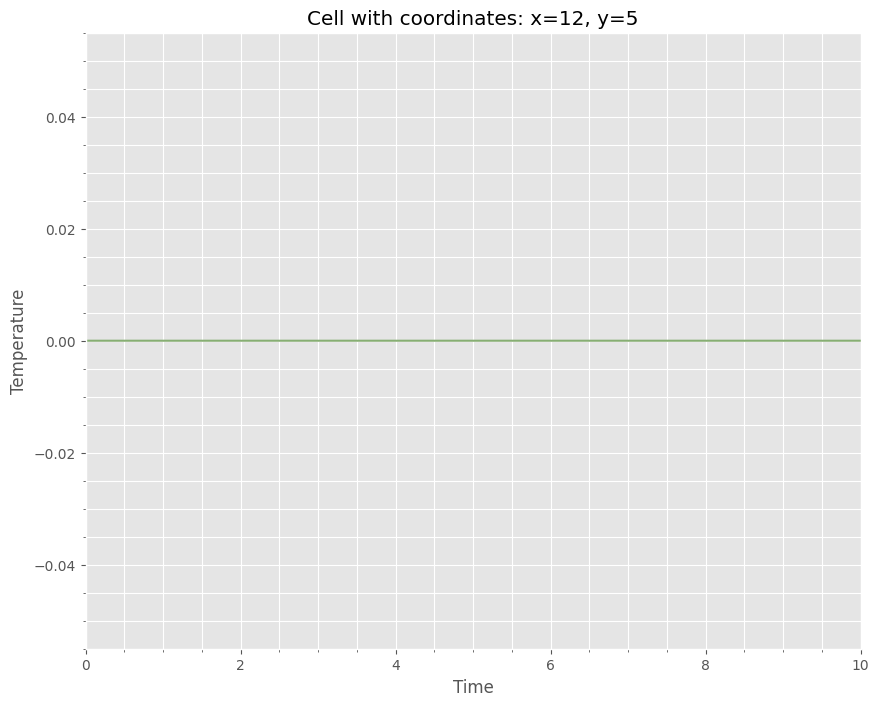

In [ ]:
coords = [(12, 5)]
plot_temperature_distribution(model, coords, plot_color='xkcd:sage')

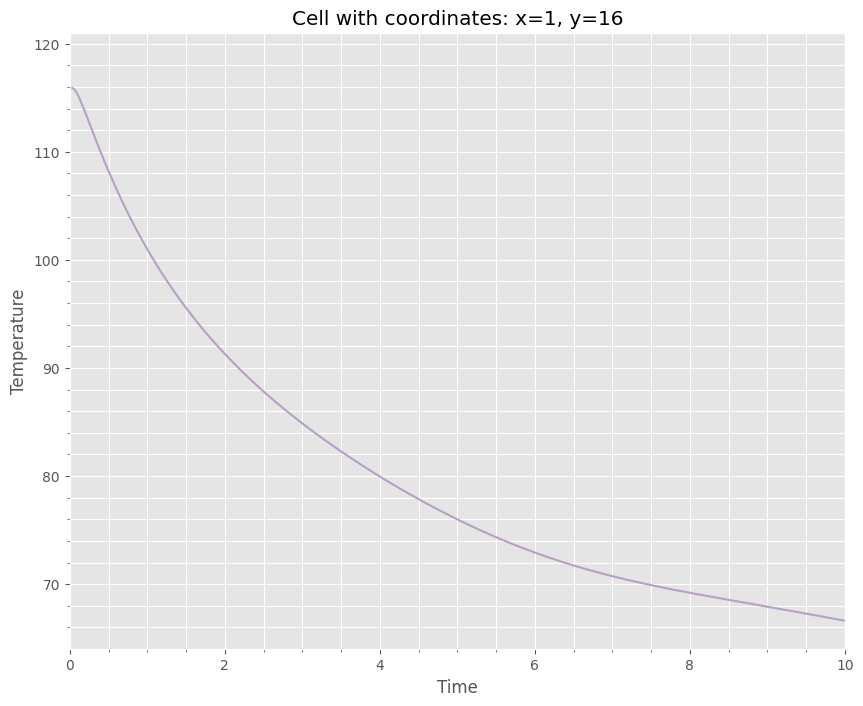

In [ ]:
coords = [(1, 16)]
plot_temperature_distribution(model, coords, plot_color="#B7A0C5")

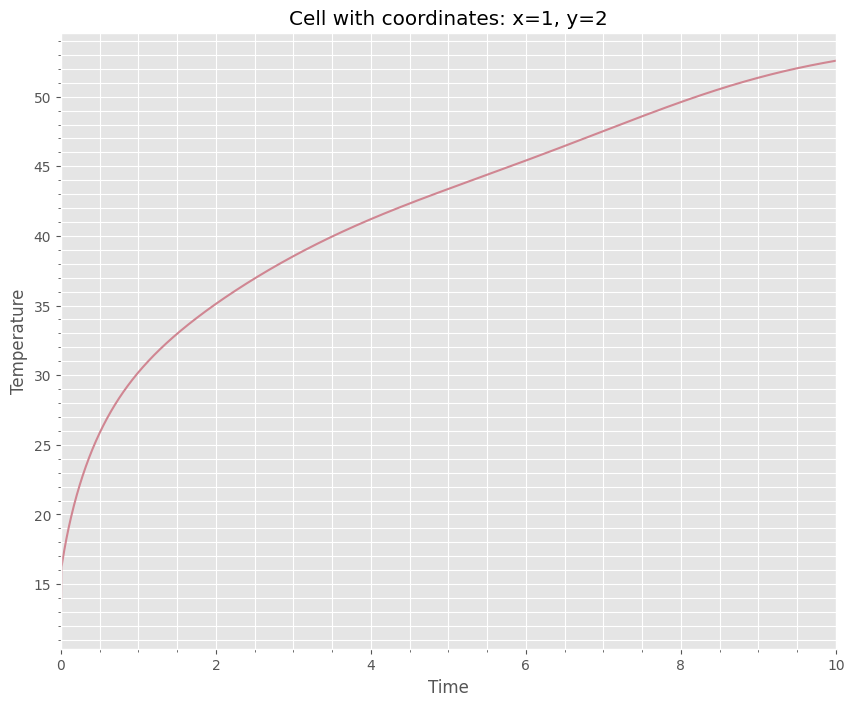

In [ ]:
coords = [(1, 2)]
plot_temperature_distribution(model, coords, plot_color='#d08692')

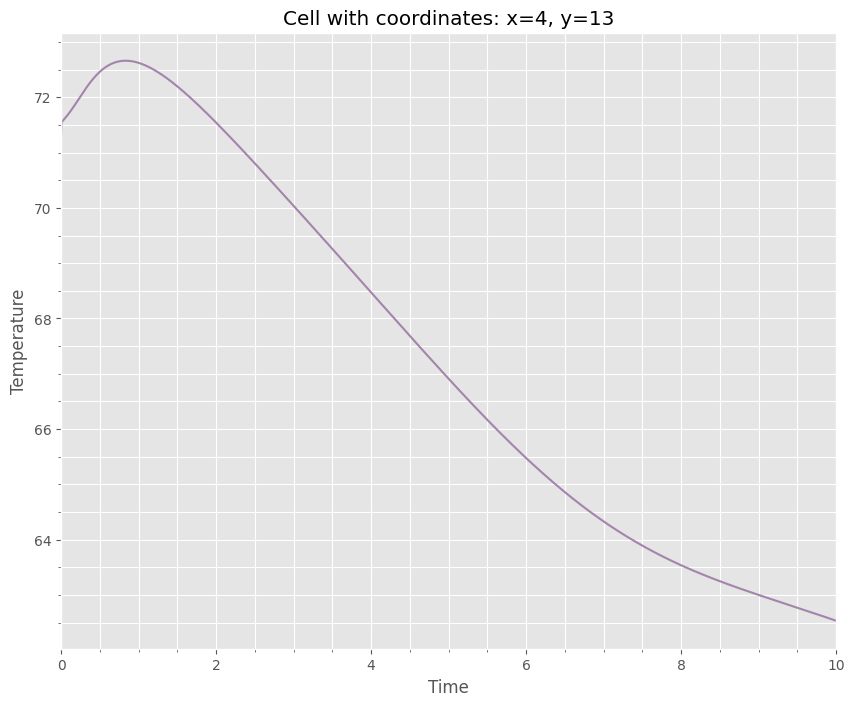

In [ ]:
coords = [(4, 13)]
plot_temperature_distribution(model, coords, plot_color='xkcd:heather')

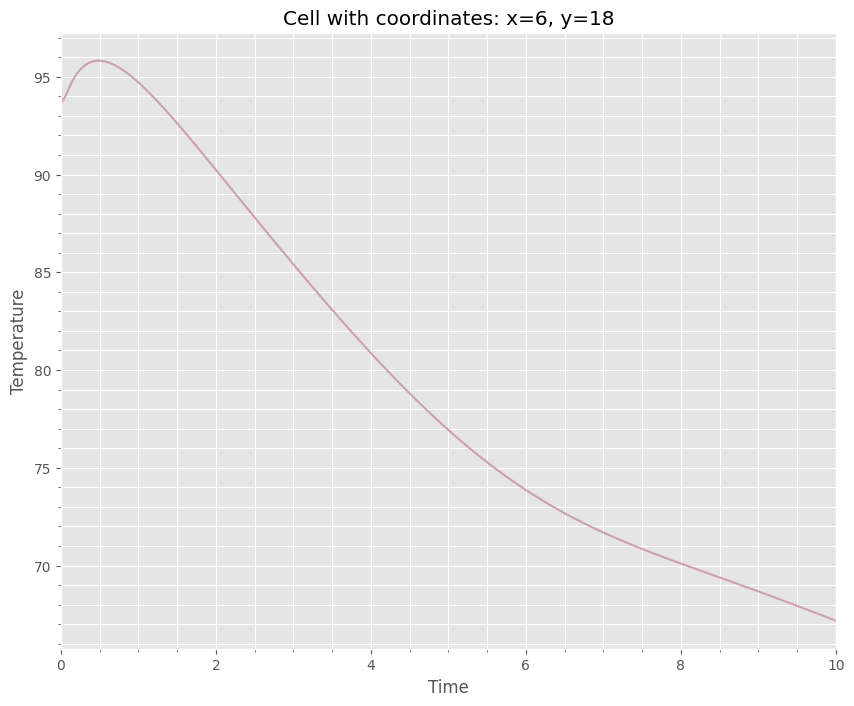

In [ ]:
coords = [(6, 18)]
plot_temperature_distribution(model, coords, plot_color='#cea0af')

### **Оценка сходимости**

Согласно теореме П. Лакса - В. С. Рябенького, решение линейной разностной задачи сходится к решению дифференциальной, если разностная задача устойчива и аппроксимирует дифференциальную задачу на ее решении. При этом порядок аппроксимации совпадает с порядком сходимости.  

Аппроксимацию получаем по построению численной схемы: при разложении в ряд Тейлора мы отбросили 4ый член погрешности, тем самым обеспечив 3ий порядок точности.

Исследуем устойчивость системы:

Говорят, что разностная схема устойчива по начальным данным, если для решения выполняется оценка $||u^{n+1}|| \leq M_1||\varphi||, \; \forall t^n \in \omega^t -$ узлы сетки по $t$, причем константа $M_1$ не зависит от сеточных параметров.






In [ ]:
def plot_function_norm(model, min_step=4, max_step=9999, figsize=(10, 7)):
    norms = [np.linalg.norm(model.u[step]) for step in range(min_step, max_step)]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)

    ax.plot(norms, color="#aa83a6", label="Norm of Function")
    ax.set_xlabel("Step")
    ax.set_ylabel("$\|\mathbf{u}\|$")
    ax.set_title("Stability analysis based on initial data")
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.minorticks_on()
    ax.legend()

    plt.show()

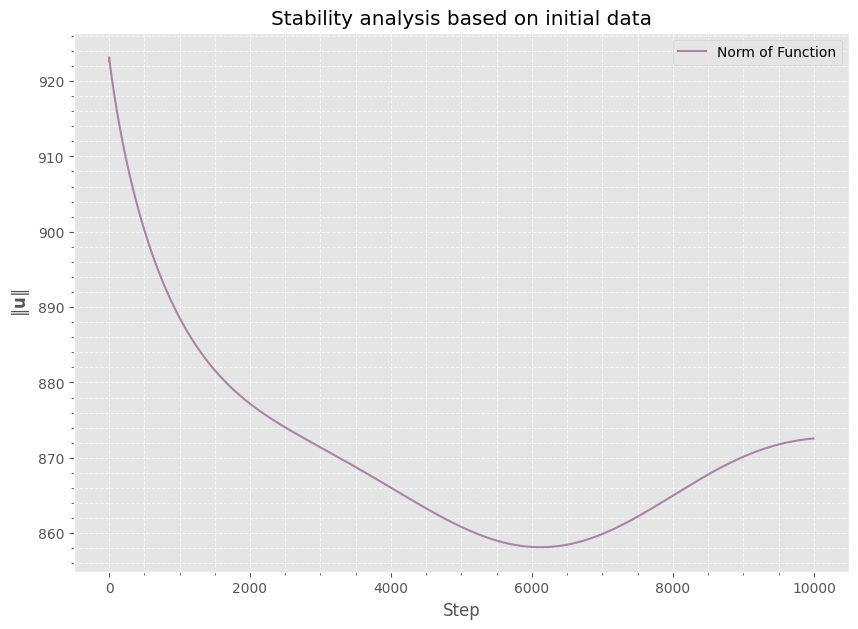

In [ ]:
plot_function_norm(model)

По графику видно, что схема - устойчива по начальным данным.

Сходимость = устойчивость + аппроксимация

Таким образом, решение сходится (порядок сходимости = порядок аппроксимации = 3).